# Bumper experiments analysis
## GOAL
The goal of this document is to load, extract, aggregate and analyze data from the experiments run with Bumper pipelines (base, standard, advanced) and gain useful insights on what can be useful in APR for dependency updates.

## Experiments structure
Bumper is evaluated on the BUMP benchmark, in three pipeline versions (base, standard and advanced).

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np

In [2]:
# Define the pipeline versions and experiment ids
# pipelines = ["baseline", "standard", "advanced"]
pipelines = ["baseline", "standard"]
experiment_ids = {
    'without_diff': "20240524_without_diff",
    "with_diff": "20240524_with_diff",
}
models = ["gpt4", "gemini", "mixtral", "llama"]
models_color = ["black", "gray", "silver", "gainsboro"]

## Helper Functions

In [3]:
def load_report(pipeline, experiment_id, model):
    path = f"benchmark/{experiment_id}/bump/{pipeline}/{model}/report.json"

    if not os.path.exists(path):
        print(f"{path} does not exist")
        return {}

    with open(path, "r") as f:
        result = json.loads(f.read())
        f.close()
        return result


def get_stats_from_report(report):
    result = {
        "number_of_projects": 0,
        "number_of_repaired_projects": 0,
        "number_of_generated_patches": 0,
        "number_of_errors": 0,
        "number_of_repaired_errors": 0,
        "percentage_of_repaired_errors": 0,
        "avg_patches_per_repair": 0,
        "avg_repair_progress": 0,
    }

    for k in report:
        project = report.get(k)
        result["avg_repair_progress"] = (
                (
                        (result["avg_repair_progress"] * result["number_of_projects"]) + min(1, project[
                    "fixed_errors_count"] / max(project["fixed_errors_count"] + project["final_errors_count"], 1))
                ) / (
                        result["number_of_projects"] + 1
                )
        )
        result["number_of_projects"] += 1
        result["number_of_repaired_projects"] += (1 if project["repaired"] else 0)
        result["number_of_generated_patches"] += project["generated_patch_count"]
        result["number_of_errors"] += (project["fixed_errors_count"] + project["final_errors_count"])
        result["number_of_repaired_errors"] += project["fixed_errors_count"]

    result["percentage_of_repaired_errors"] = result["number_of_repaired_errors"] / max(result["number_of_errors"], 1)
    result["avg_patches_per_repair"] = result["number_of_generated_patches"] / max(result["number_of_repaired_errors"],
                                                                                   1)

    return result


def get_stats_per_model(pipeline, experiment):
    data = {}
    for model in models:
        data[model] = get_stats_from_report(load_report(pipeline, experiment_ids[experiment], model))
    return data


def get_stats_per_project(pipeline, experiment):
    data = {}
    for model in models:
        report = load_report(pipeline, experiment_ids[experiment], model)
        for project in report:
            if data.get(project, None) is None:
                data[project] = {}

            data[project][model] = report[project]
    return data


def plot_stats(stats, filename=None):
    df = pd.DataFrame.from_dict(stats, orient="index")
    colors = models_color

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    fig.tight_layout(pad=2.5)

    df["avg_repair_progress"].plot(ax=axes[0][0], kind='barh', stacked=False, title='Average progress in repair',
                                   color=colors)
    axes[0][0].set_xticks([x / 100.0 for x in range(0, 101, 25)])

    df["avg_patches_per_repair"].plot(ax=axes[0][1], kind='barh', stacked=False, title='Avg Patches for Repaired Error',
                                      color=colors)
    axes[0][1].set_xticks(range(0, 10, 1))

    df["number_of_repaired_projects"].plot(
        ax=axes[1][0],
        kind='barh',
        stacked=False,
        title='Number of Repaired Projects',
        color=colors,
    )
    axes[1][0].set_xticks(range(0, 40, 5))

    df["percentage_of_repaired_errors"].plot(ax=axes[1][1], kind='barh', stacked=False,
                                             title='Percentage of Repaired Errors', color=colors)
    axes[1][1].set_xticks([x / 100.0 for x in range(0, 101, 25)])

    if filename is not None:
        fig.savefig(f"images/{filename}.png")


# Base pipeline performance
## Without api diff (Baseline)

In [4]:
stats = get_stats_per_model("baseline", "without_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,1.000000,2.000000,1.000000,2.000000
number_of_generated_patches,364.000000,232.000000,169.000000,326.000000
number_of_errors,190.000000,122.000000,96.000000,173.000000
number_of_repaired_errors,115.000000,47.000000,37.000000,91.000000
percentage_of_repaired_errors,0.605263,0.385246,0.385417,0.526012
avg_patches_per_repair,3.165217,4.936170,4.567568,3.582418
avg_repair_progress,0.302579,0.290794,0.270918,0.383469


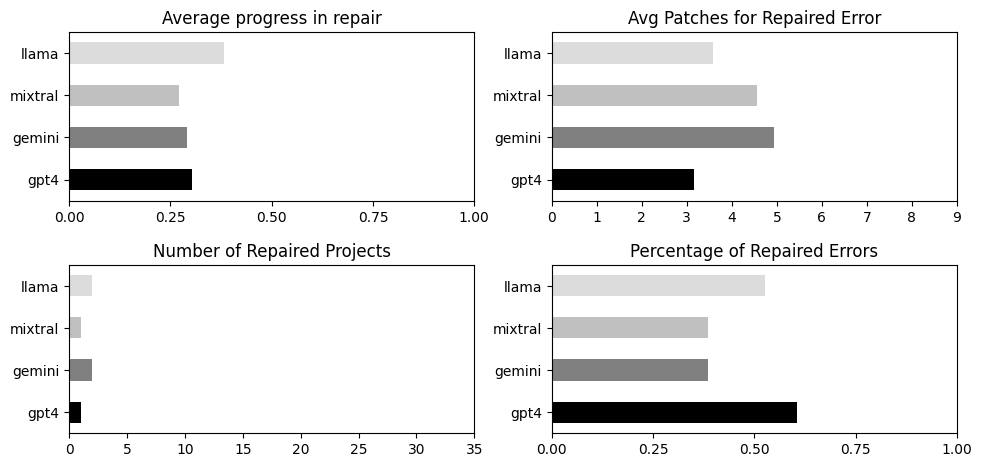

In [5]:
stats = get_stats_per_model("baseline", "without_diff")
plot_stats(stats, "baseline_no_diff")

## With api diff

In [6]:
stats = get_stats_per_model("baseline", "with_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,4.000000,5.000000,3.000000,5.000000
number_of_generated_patches,286.000000,329.000000,277.000000,354.000000
number_of_errors,195.000000,150.000000,181.000000,174.000000
number_of_repaired_errors,152.000000,104.000000,117.000000,117.000000
percentage_of_repaired_errors,0.779487,0.693333,0.646409,0.672414
avg_patches_per_repair,1.881579,3.163462,2.367521,3.025641
avg_repair_progress,0.506746,0.476359,0.404004,0.485119


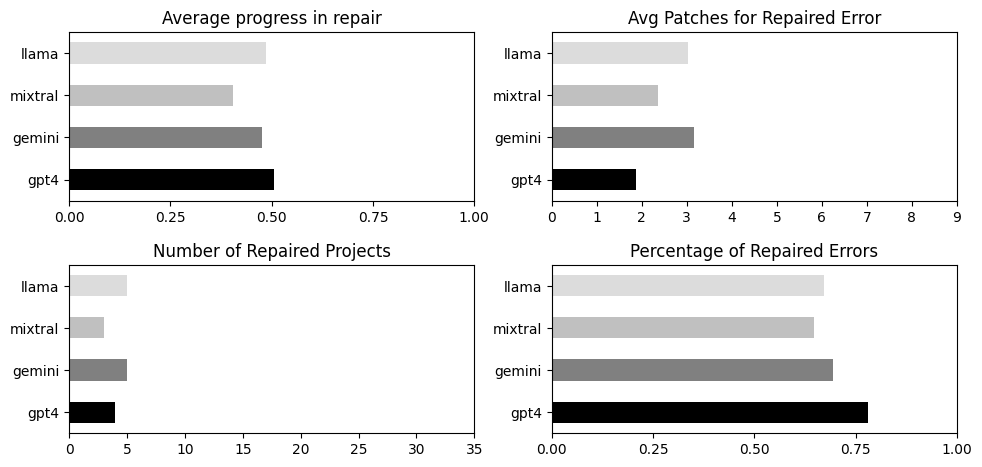

In [7]:
stats = get_stats_per_model("baseline", "with_diff")
plot_stats(stats, "baseline_with_diff")

## Standard
### Without api diff

In [8]:
stats = get_stats_per_model("standard", "without_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,10.000000,6.000000,4.000000,6.000000
number_of_generated_patches,253.000000,291.000000,222.000000,234.000000
number_of_errors,213.000000,171.000000,145.000000,210.000000
number_of_repaired_errors,189.000000,133.000000,109.000000,172.000000
percentage_of_repaired_errors,0.887324,0.777778,0.751724,0.819048
avg_patches_per_repair,1.338624,2.187970,2.036697,1.360465
avg_repair_progress,0.752329,0.616574,0.542568,0.594218


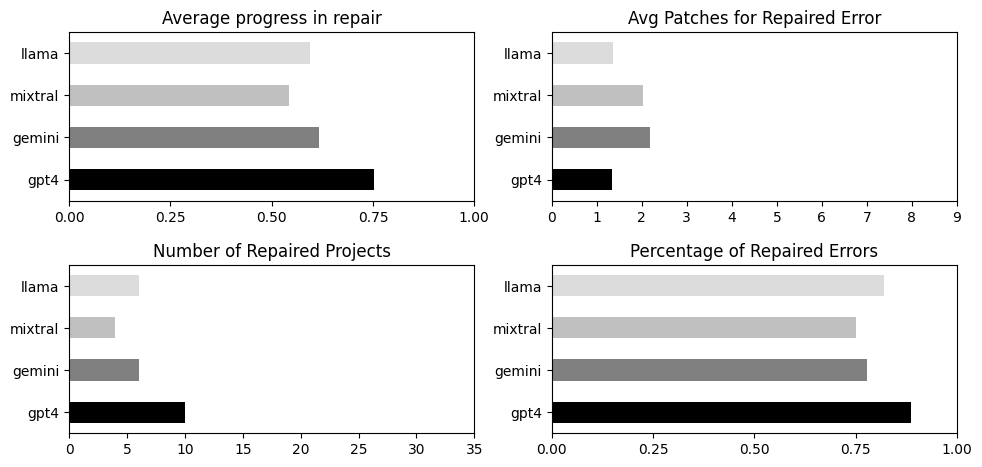

In [9]:
stats = get_stats_per_model("standard", "without_diff")
plot_stats(stats, "standard_no_diff")

## With api diff

In [10]:
stats = get_stats_per_model("standard", "with_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,10.000000,5.000000,3.000000,5.000000
number_of_generated_patches,247.000000,292.000000,168.000000,211.000000
number_of_errors,209.000000,179.000000,130.000000,198.000000
number_of_repaired_errors,185.000000,139.000000,90.000000,167.000000
percentage_of_repaired_errors,0.885167,0.776536,0.692308,0.843434
avg_patches_per_repair,1.335135,2.100719,1.866667,1.263473
avg_repair_progress,0.752329,0.586176,0.508061,0.602329


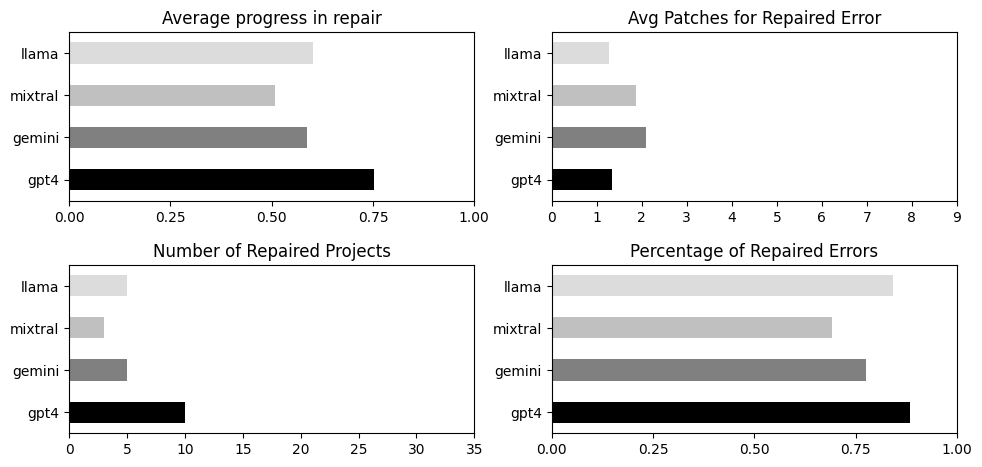

In [11]:
stats = get_stats_per_model("standard", "with_diff")
plot_stats(stats, "standard_with_diff")

## Advanced
### With API Diff

In [12]:
stats = get_stats_per_model("advanced", "with_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,11.000000,6.000000,5.000000,6.000000
number_of_generated_patches,226.000000,362.000000,199.000000,219.000000
number_of_errors,209.000000,196.000000,146.000000,198.000000
number_of_repaired_errors,185.000000,154.000000,106.000000,167.000000
percentage_of_repaired_errors,0.885167,0.785714,0.726027,0.843434
avg_patches_per_repair,1.221622,2.350649,1.877358,1.311377
avg_repair_progress,0.761853,0.624051,0.539275,0.621377


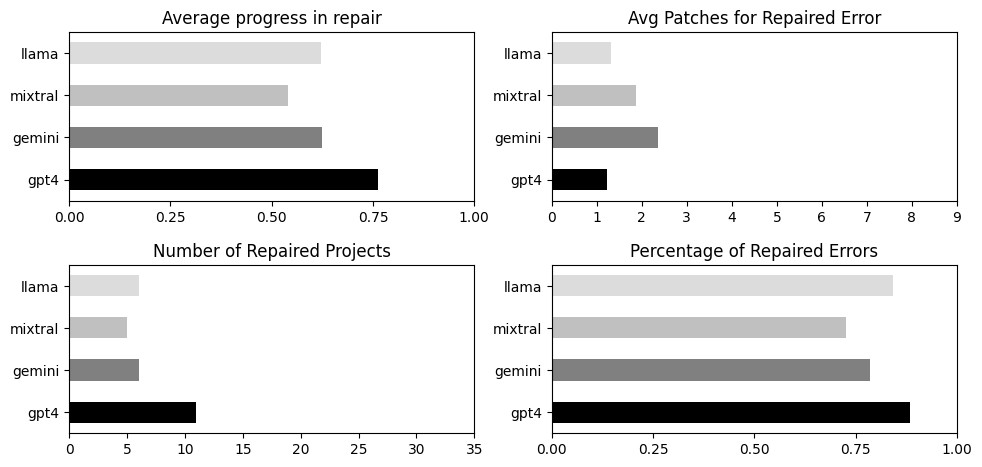

In [13]:
stats = get_stats_per_model("advanced", "with_diff")
plot_stats(stats, "advanced_with_diff")

# RQ4: Comparison between models
## baseline 

In [14]:
labels = [
    "Generic pipeline\nwithout API Diffs",
    "Generic pipeline\nwith API Diffs",
    "Specialized pipeline\nwithout API Diffs",
    "Specialized pipeline\nwith API Diffs",
    # "Advanced\nwithout API Diffs",
    # "Advanced\nwith API Diffs"
]

In [15]:
stats = {}
for pipeline in pipelines:
    stats[pipeline] = {
        "without_diff": get_stats_per_model(pipeline, "without_diff"),
        "with_diff": get_stats_per_model(pipeline, "with_diff")
    }

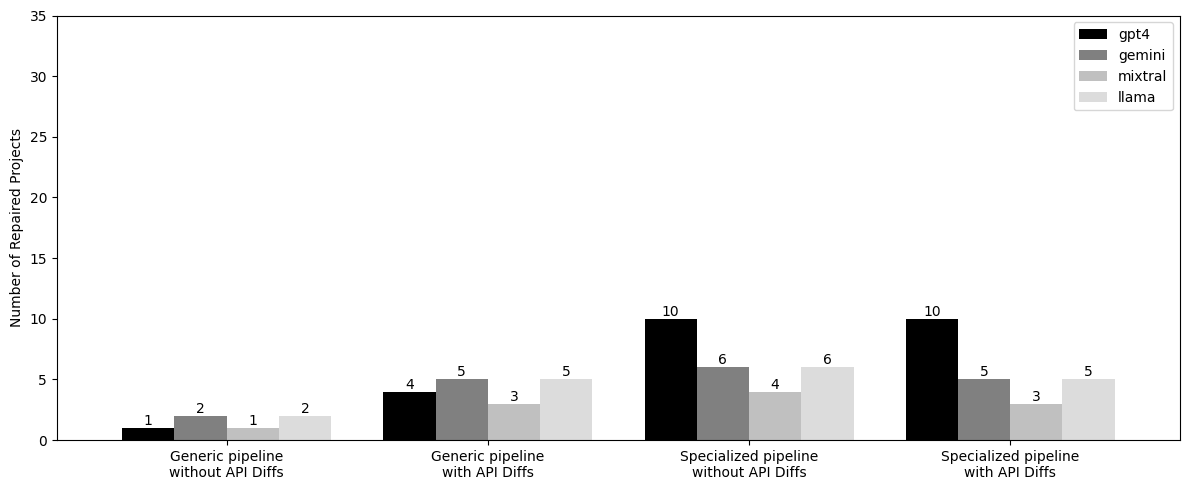

In [16]:
extracted_data = []

for pipeline, diff_data in stats.items():
    for diff, models in diff_data.items():
        for model, metrics in models.items():
            extracted_data.append([pipeline, diff, model, metrics['number_of_repaired_projects']])

df = pd.DataFrame(extracted_data, columns=['Pipeline', 'Diff', 'Model', 'Number of Repaired Projects'])

pipeline_order = ['baseline', 'standard', 'advanced']
model_order = ["gpt4", "gemini", "mixtral", "llama"]

# Setting categorical types to enforce order
df['Pipeline'] = pd.Categorical(df['Pipeline'], categories=pipeline_order, ordered=True)
df['Diff'] = pd.Categorical(df['Diff'], categories=["without_diff", "with_diff"], ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

# Sorting the DataFrame based on the desired order
df = df.sort_values(by=['Pipeline', 'Diff', 'Model'])

# Pivoting the data for better visualization
pivot_df = df.pivot_table(values='Number of Repaired Projects', index=['Pipeline', 'Diff'], columns='Model',
                          aggfunc='first', observed=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

bars = pivot_df.set_index(['Pipeline', 'Diff']).plot(kind='bar', ax=ax, width=0.8, color=models_color)
ax.set_ylim(0, 35)
ax.set_xticklabels(labels)

plt.title('')
plt.ylabel('Number of Repaired Projects')
plt.xlabel("")
plt.xticks(rotation=0, ha='center')

plt.legend(title='')
plt.tight_layout()

# Adding value annotations on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',  # Assuming the values are integers
        ha='center',
        va='bottom'
    )

plt.show()
fig.savefig(f"images/RQ4_projects.pdf", format="pdf")
fig.savefig(f"images/RQ4_projects.png", format="png")
fig.savefig(f"images/RQ4_projects.svg", format="svg")

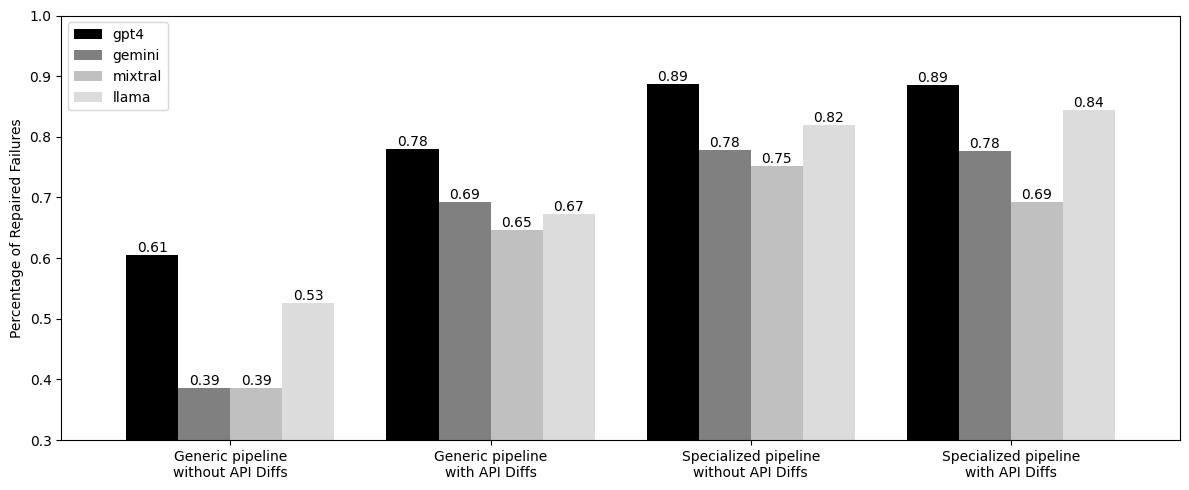

In [17]:
extracted_data = []

for pipeline, diff_data in stats.items():
    for diff, models in diff_data.items():
        for model, metrics in models.items():
            extracted_data.append([pipeline, diff, model, metrics['percentage_of_repaired_errors']])

df = pd.DataFrame(extracted_data, columns=['Pipeline', 'Diff', 'Model', 'Percentage of Repaired Failures'])

pipeline_order = ['baseline', 'standard', 'advanced']
model_order = ["gpt4", "gemini", "mixtral", "llama"]

# Setting categorical types to enforce order
df['Pipeline'] = pd.Categorical(df['Pipeline'], categories=pipeline_order, ordered=True)
df['Diff'] = pd.Categorical(df['Diff'], categories=["without_diff", "with_diff"], ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

# Sorting the DataFrame based on the desired order
df = df.sort_values(by=['Pipeline', 'Diff', 'Model'])

# Pivoting the data for better visualization
pivot_df = df.pivot_table(values='Percentage of Repaired Failures', index=['Pipeline', 'Diff'], columns='Model',
                          aggfunc='first', observed=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

pivot_df.set_index(['Pipeline', 'Diff']).plot(kind='bar', ax=ax, width=0.8, color=models_color)
ax.set_ylim(0.3, 1)
ax.set_xticklabels(labels)

plt.title('')
plt.ylabel('Percentage of Repaired Failures')
plt.xlabel("")
plt.xticks(rotation=0, ha='center')

plt.legend(title='', loc="upper left")
plt.tight_layout()

# Adding value annotations on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        '{:.2f}'.format(height),  # Assuming the values are integers
        ha='center',
        va='bottom'
    )
    
plt.show()
fig.savefig(f"images/RQ4_failures.pdf", format="pdf")

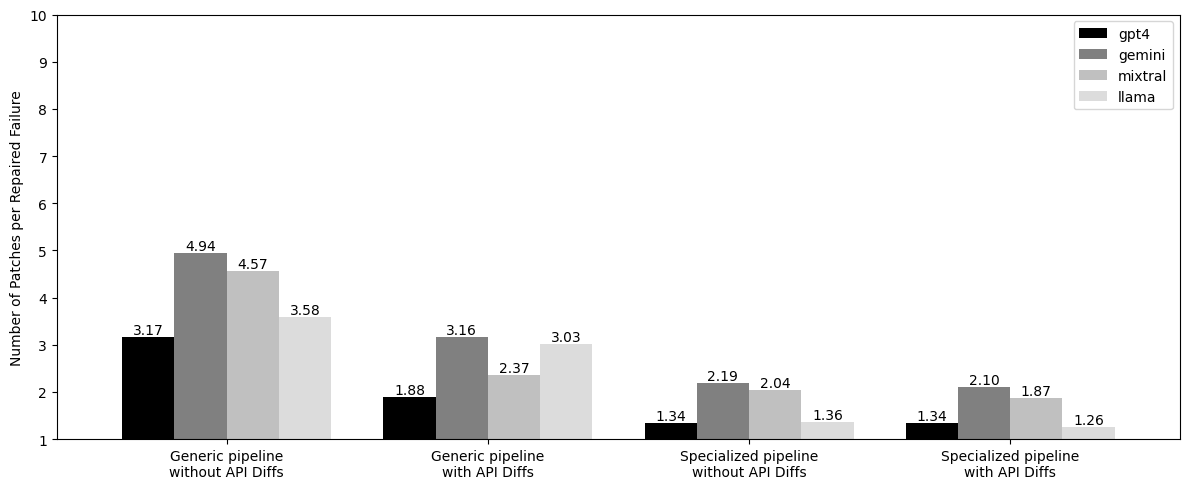

In [18]:
extracted_data = []

for pipeline, diff_data in stats.items():
    for diff, models in diff_data.items():
        for model, metrics in models.items():
            extracted_data.append([pipeline, diff, model, metrics['avg_patches_per_repair']])

df = pd.DataFrame(extracted_data, columns=['Pipeline', 'Diff', 'Model', 'Patches per Repaired Failure'])

pipeline_order = ['baseline', 'standard', 'advanced']
model_order = ["gpt4", "gemini", "mixtral", "llama"]

# Setting categorical types to enforce order
df['Pipeline'] = pd.Categorical(df['Pipeline'], categories=pipeline_order, ordered=True)
df['Diff'] = pd.Categorical(df['Diff'], categories=["without_diff", "with_diff"], ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

# Sorting the DataFrame based on the desired order
df = df.sort_values(by=['Pipeline', 'Diff', 'Model'])

# Pivoting the data for better visualization
pivot_df = df.pivot_table(values='Patches per Repaired Failure', index=['Pipeline', 'Diff'], columns='Model',
                          aggfunc='first', observed=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

pivot_df.set_index(['Pipeline', 'Diff']).plot(kind='bar', ax=ax, width=0.8, color=models_color)
ax.set_ylim(1, 10)
ax.set_xticklabels(labels)

plt.title('')
plt.ylabel('Number of Patches per Repaired Failure')
plt.xlabel("")
plt.xticks(rotation=0, ha='center')

plt.legend(title='')
plt.tight_layout()

# Adding value annotations on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        '{:.2f}'.format(height),  # Assuming the values are integers
        ha='center',
        va='bottom'
    )
    
    
plt.show()
fig.savefig("images/RQ4_patches.pdf", format="pdf")

In [19]:
baseline = pd.DataFrame(get_stats_per_model("baseline", "without_diff"))
standard = pd.DataFrame(get_stats_per_model("standard", "without_diff"))

In [20]:
changes = (standard / baseline) - 1
changes

,gpt4,gemini,mixtral,llama
number_of_projects,0.000000,0.000000,0.000000,0.000000
number_of_repaired_projects,9.000000,2.000000,3.000000,2.000000
number_of_generated_patches,-0.304945,0.254310,0.313609,-0.282209
number_of_errors,0.121053,0.401639,0.510417,0.213873
number_of_repaired_errors,0.643478,1.829787,1.945946,0.890110
percentage_of_repaired_errors,0.466013,1.018913,0.950419,0.557091
avg_patches_per_repair,-0.577083,-0.556747,-0.554096,-0.620238
avg_repair_progress,1.486386,1.120311,1.002699,0.549583


In [21]:
changes.transpose().describe()

,number_of_projects,number_of_repaired_projects,number_of_generated_patches,number_of_errors,number_of_repaired_errors,percentage_of_repaired_errors,avg_patches_per_repair,avg_repair_progress
count,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.0,4.000000,-0.004808,0.311745,1.327330,0.748109,-0.577041,1.039745
std,0.0,3.366502,0.334447,0.176535,0.656750,0.277086,0.030574,0.386269
min,0.0,2.000000,-0.304945,0.121053,0.643478,0.466013,-0.620238,0.549583
25%,0.0,2.000000,-0.287893,0.190668,0.828452,0.534321,-0.587872,0.889420
50%,0.0,2.500000,-0.013949,0.307756,1.359949,0.753755,-0.566915,1.061505
75%,0.0,4.500000,0.269135,0.428834,1.858827,0.967543,-0.556085,1.211830
max,0.0,9.000000,0.313609,0.510417,1.945946,1.018913,-0.554096,1.486386


# Cost efficiency

In [22]:
stats = {}
for pipeline in pipelines:
    stats[pipeline] = {
        "without_diff": get_stats_per_model(pipeline, "without_diff"),
        "with_diff": get_stats_per_model(pipeline, "with_diff")
    }
patches_generated = None
for pipeline in pipelines:
    if patches_generated is None:
        patches_generated = pd.DataFrame(get_stats_per_model(pipeline, "without_diff"))
    else:
        patches_generated += pd.DataFrame(get_stats_per_model(pipeline, "without_diff"))
            
    patches_generated += pd.DataFrame(get_stats_per_model(pipeline, "with_diff"))
patches_generated = pd.DataFrame(patches_generated.transpose()["number_of_generated_patches"])
patches_generated = patches_generated.to_numpy()

In [23]:
model_order = ["gpt4", "gemini", "mixtral", "llama"]
costs = pd.DataFrame({
    "gpt4": {"cost": 468.78},
    "gemini": {"cost": 13.41},
    "mixtral": {"cost": 0},
    "llama": {"cost": 0},
}).transpose()
costs = costs.to_numpy()
costs

array([[468.78],
       [ 13.41],
       [  0.  ],
       [  0.  ]])

In [24]:
cost_per_patch = costs / patches_generated
cost_per_patch

array([[0.40763478],
       [0.01172203],
       [0.        ],
       [0.        ]])

## Tokens per patch

In [25]:
%reload_ext dotenv
%dotenv

In [26]:
import vertexai
from vertexai.generative_models import GenerativeModel
from transformers import AutoTokenizer

def gemini_enc(text: str):
    project_id = os.getenv("GOOGLE_CLOUD_PROJECT_ID")
    vertexai.init(
        project=project_id, 
        location=os.getenv("GOOGLE_CLOUD_REGION"),
    )
    model = GenerativeModel(model_name="gemini-pro")
    # Prompt tokens count
    return model.count_tokens(text).total_tokens

def hf_enc(model_id: str):
    def _enc(text: str):
        tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.getenv("HF_KEY"))
        return len(tokenizer.tokenize(text))
    
    return _enc
    

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [29]:
import tiktoken
from tqdm.notebook import tqdm
 
def gpt_enc(text: str):
    return len(
        tiktoken.encoding_for_model("gpt-4").encode(text)
    )

def get_avg_tokens_in_folder(path: str, enc):
    patches = []
    for project in tqdm(os.listdir(path), desc=path, leave=False):
    # for project in os.listdir(path):
        if ".json" in project: 
            continue
            
        for patch_id in tqdm(os.listdir(os.path.join(path, project, "patches")), desc=project, leave=False):
        # for patch_id in os.listdir(os.path.join(path, project, "patches")):
            patch_token_count = None
            patch_path = os.path.join(path, project, "patches", patch_id)
            if os.path.exists(os.path.join(patch_path, "token_count.txt")):
                with open(os.path.join(patch_path, "token_count.txt"), "r") as file:
                    saved_data = (file.read() or "").split(",")
                    if len(saved_data) == 2:
                        patch_token_count = (int(saved_data[0]), int(saved_data[1]))
                    file.close()
                
            if patch_token_count is None and os.path.exists(os.path.join(patch_path, "prompt.txt")):
                with open(os.path.join(patch_path, "prompt.txt"), "r") as file:
                    prompt_token_count = enc(file.read())
                    file.close()
                    
                with open(os.path.join(patch_path, "model_response.md"), "r") as file:
                    output_token_count = enc(file.read())
                    file.close()
                
                with open(os.path.join(patch_path, "token_count.txt"), "w") as file:
                    file.write(f"{prompt_token_count},{output_token_count}")
                    file.close()
                
                patch_token_count = (prompt_token_count, output_token_count)
                    
            if patch_token_count is not None:
                patches.append(patch_token_count)
                        
    return patches

In [30]:
result = {}
for pipeline in ["baseline", "standard"]:
    result[pipeline] = {
        "without_diff": {
            "gpt4": get_avg_tokens_in_folder(
                f"./benchmark/20240524_without_diff/bump/{pipeline}/gpt4", 
                enc=gpt_enc
            ),
            "gemini": get_avg_tokens_in_folder(
                f"./benchmark/20240524_without_diff/bump/{pipeline}/gemini", 
                enc=gemini_enc
            ),
            "mixtral": get_avg_tokens_in_folder(
                f"./benchmark/20240524_without_diff/bump/{pipeline}/mixtral", 
                enc=hf_enc(model_id="mistralai/Mixtral-8x7B-Instruct-v0.1")
            ),
            "llama": get_avg_tokens_in_folder(
                f"./benchmark/20240524_without_diff/bump/{pipeline}/llama", 
                enc=hf_enc(model_id="meta-llama/Meta-Llama-3-70B")
            ),
        },
        "with_diff": {
            "gpt4": get_avg_tokens_in_folder(
                f"./benchmark/20240524_with_diff/bump/{pipeline}/gpt4", 
                enc=gpt_enc
            ),
            "gemini": get_avg_tokens_in_folder(
                f"./benchmark/20240524_with_diff/bump/{pipeline}/gemini", 
                enc=gemini_enc
            ),
            "mixtral": get_avg_tokens_in_folder(
                f"./benchmark/20240524_with_diff/bump/{pipeline}/mixtral", 
                enc=hf_enc(model_id="mistralai/Mixtral-8x7B-Instruct-v0.1")
            ),
            "llama": get_avg_tokens_in_folder(
                f"./benchmark/20240524_with_diff/bump/{pipeline}/llama", 
                enc=hf_enc(model_id="meta-llama/Meta-Llama-3-70B")
            ),
        },
    }

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


3572a1ecc0154c61e05505aed56055b9c5e539a6:   0%|          | 0/13 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make s

d38182a8a0fe1ec039aed97e103864fce717a0be:   0%|          | 0/21 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make s

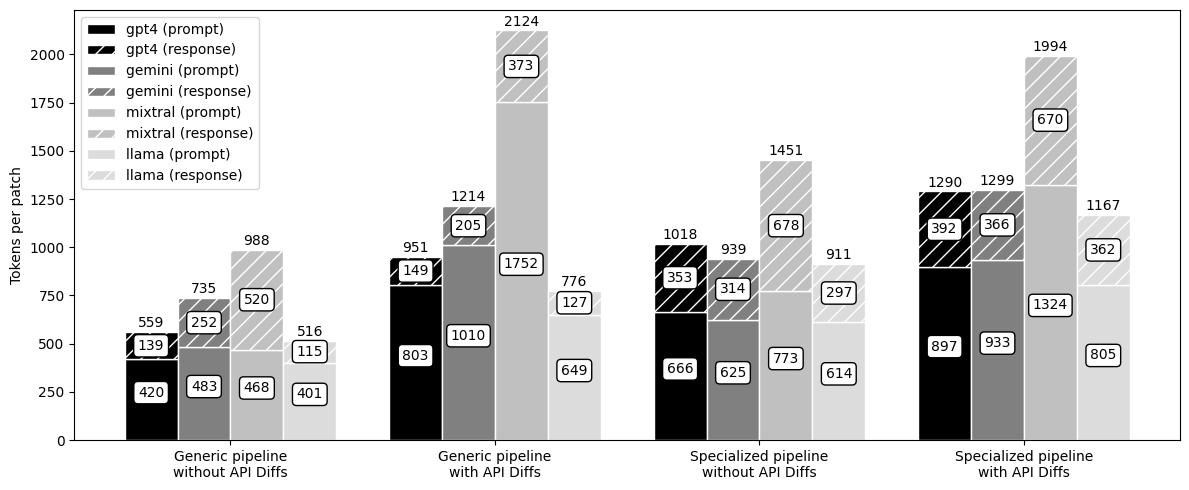

In [71]:
# Extract categories and sub-categories
categories = list(result.keys())
sub_categories = ['without_diff', 'with_diff']
models = ['gpt4', 'gemini', 'mixtral', 'llama']

# Prepare data for plotting
input_values = []
output_values = []

for category in categories:
    for sub_category in sub_categories:
        input_value = []
        output_value = []
        for model in models:
            values = pd.DataFrame(result[category][sub_category][model]).mean()
            input_value.append(values[0])
            output_value.append(values[1])
            
        input_values.append(input_value)
        output_values.append(output_value)

input_values = np.array(input_values).T  # Transpose for plotting
output_values = np.array(output_values).T  # Transpose for plotting

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 0.20
index = np.arange(len(categories) * len(sub_categories))

# Bar positions
bar_positions = [
    index - 1.5*bar_width,
    index - 0.5*bar_width,
    index + 0.5*bar_width,
    index + 1.5*bar_width,
]
# bar2_positions = index - bar_width/2
# bar1_positions = index + bar_width/2
# bar1_positions = index + bar_width/2
# bar1_positions = index + bar_width/2

bars = []

for i, model in enumerate(models):
    bars.extend([
        ax.bar(bar_positions[i], input_values[i], bar_width, label=f"{model} (prompt)", color=models_color[i], edgecolor='white'),
        ax.bar(bar_positions[i], output_values[i], bar_width, bottom=input_values[i], label=f"{model} (response)", color=models_color[i], edgecolor='white', hatch="//"),
    ])

# Plot bars
# bars1 = ax.bar(bar_positions[1], input_values[0], bar_width, label='GPT-4 (Prompt)', color="red", edgecolor='red')
# bars2 = ax.bar(bar2_positions, output_values[0], bar_width, bottom=input_values[0], label="GPT-4 (Response)", color="black", hatch="//", edgecolor="white")
# 
# bars3 = ax.bar(bar1_positions, input_values[1], bar_width, label='Gemini (Prompt)', color="gray", edgecolor='white')
# bars4 = ax.bar(bar1_positions, output_values[1], bar_width, bottom=input_values[1], label="Gemini (Response)", color="gray", hatch="//", edgecolor="white")
# 
# bars5 = ax.bar(bar1_positions, input_values[2], bar_width, label='Mixtral (Prompt)', color="gray", edgecolor='white')
# bars6 = ax.bar(bar1_positions, output_values[2], bar_width, bottom=input_values[2], label="Mixtral (Response)", color="gray", hatch="//", edgecolor="white")

# Labels and title
# ax.set_xlabel('Pipeline Type')
ax.set_ylabel('Tokens per patch')
# ax.set_title('Token per patch by pipeline type and model')
ax.set_xticks(index)
ax.set_xticklabels(labels)
# ax.set_ylim([0, 1400])
ax.legend()

for i, (input_val, output_val) in enumerate(zip(input_values, output_values)):
    for bar, inp, out in zip(bars[i * 2], input_val, output_val):
        height = inp + out
        ax.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height:.0f}', ha='center', va='bottom')
        ax.text(bar.get_x() + bar.get_width() / 2, inp / 2, f'{inp:.0f}', ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        ax.text(bar.get_x() + bar.get_width() / 2, inp + (out / 2), f'{out:.0f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))


# Add total value (sum) of each bar on top
# for bars, input_val, output_val in [(bars1, input_values[0], output_values[0]), (bars2, input_values[0], output_values[0]), 
#                                     (bars3, input_values[1], output_values[1]), (bars4, input_values[1], output_values[1])]:
#     for bar, inp, out in zip(bars, input_val, output_val):
#         height = inp + out
#         ax.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height:.0f}', ha='center', va='bottom')
#         ax.text(bar.get_x() + bar.get_width() / 2, inp / 2, f'{inp:.0f}', ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
#         ax.text(bar.get_x() + bar.get_width() / 2, inp + (out / 2), f'{out:.0f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))


# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f"images/token_count.pdf", format="pdf")

In [72]:
models_df = pd.DataFrame({"model": ["gpt-4", "gemini"]})
df = models_df.join(pd.DataFrame(input_values))
df.columns = ["model", "baseline no-diff", "baseline with-diff", "standard no-diff", "standard with-diff"]
df

,model,baseline no-diff,baseline with-diff,standard no-diff,standard with-diff
0,gpt-4,419.558585,802.582873,665.519294,897.381840
1,gemini,482.750743,1009.503067,625.319423,933.050937


In [73]:
models_df = pd.DataFrame({"model": ["gpt-4", "gemini"]})
df = models_df.join(pd.DataFrame(output_values))
df.columns = ["model", "baseline no-diff", "baseline with-diff", "standard no-diff", "standard with-diff"]
df

,model,baseline no-diff,baseline with-diff,standard no-diff,standard with-diff
0,gpt-4,138.991879,148.748619,352.888162,392.257366
1,gemini,252.369177,204.779141,313.650986,366.017564


In [74]:
{"gpt4": (897 / 1000 * 0.03) + (392 / 1000 * 0.06), "gemini": (933 / 1000 * 0.0005) + (366 / 1000 * 0.0015)}

{'gpt4': 0.05043, 'gemini': 0.0010155}